# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

In [5]:
!pip install transformers

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

In [6]:
!curl https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1 -o arguments-training.tsv
!curl https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1 -o arguments-validation.tsv
!curl https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1 -o arguments-test.tsv
!curl https://zenodo.org/records/8248658/files/labels-training.tsv?download=1 -o labels-training.tsv
!curl https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1 -o labels-validation.tsv
!curl https://zenodo.org/records/8248658/files/labels-test.tsv?download=1 -o labels-test.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k  100  988k    0     0   647k      0  0:00:01  0:00:01 --:--:--  648k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  354k  100  354k    0     0   351k      0  0:00:01  0:00:01 --:--:--  352k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283k  100  283k    0     0   278k      0  0:00:01  0:00:01 --:--:--  278k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   266k      0 --:--:-- --:--:-- --:--:--  266k
  % Total    % Received % Xferd  Average Speed   Tim

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [7]:
import copy
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torcheval.metrics.functional import binary_f1_score
from transformers import AutoTokenizer, AutoModel

from file_reader import import_features, import_labels
from dataframe_modifier import modify_stance, create_third_level_labels
from CustomDataset import CustomDataset
from network_trainer import train, evaluate_model
from plots import generate_summary, generate_precision_recall_curve, generate_confusion_matrix, \
    generate_f1_scores_table, generate_bar_plot_with_f1_scores, generate_training_history_plots


save_best_models = True
load_best_models = False
models_load_path = 'best_models.tar'
models_save_path = 'best_models.tar'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_id = 1
models_dict = [{'name': 'bert-base-uncased', 'head_size': 768},
               {'name': 'roberta-base', 'head_size': 768},
               {'name': 'roberta-large', 'head_size': 1024}]

initializer_seed = 111
seeds = [876,
         555,
         777
         ]

num_epochs = 10

In [8]:
random.seed(initializer_seed)
np.random.seed(initializer_seed)
torch.manual_seed(initializer_seed)

train_dataframe, validation_dataframe, test_dataframe = import_features()
lab_train_dataframe, lab_validation_dataframe, lab_test_dataframe = import_labels()
modify_stance(train_dataframe, validation_dataframe, test_dataframe)

third_level_train_dataframe, third_level_validation_dataframe, third_level_test_dataframe = \
    create_third_level_labels(lab_train_dataframe, lab_validation_dataframe, lab_test_dataframe)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(models_dict[model_id]['name'])

# Generate datasets and dataloaders
training_set = CustomDataset(train_dataframe, third_level_train_dataframe, tokenizer)
validation_set = CustomDataset(validation_dataframe, third_level_validation_dataframe, tokenizer)
test_set = CustomDataset(test_dataframe, third_level_test_dataframe, tokenizer)

training_loader = DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

In [9]:
def random_uniform_classifier(test_labels):
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.random.randint(2, size=(n_instances, n_classes))
    predictions = torch.Tensor(predictions)
    return predictions


def majority_classifier(training_labels, test_labels):
    training_labels = training_labels.values
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.zeros((n_instances, n_classes))
    for i in range(n_classes):
        if np.sum(training_labels[:, i]) >= len(training_labels) / 2:
            predictions[:, i] = 1
    predictions = torch.Tensor(predictions)
    return predictions


def one_baseline(test_labels):
    test_labels = test_labels.values
    n_instances = test_labels.shape[0]
    n_classes = test_labels.shape[1]

    predictions = np.ones((n_instances, n_classes))
    predictions = torch.Tensor(predictions)
    return predictions


# Baselines
# 1. Random
predictions_random = random_uniform_classifier(third_level_test_dataframe)
val_predictions_random = random_uniform_classifier(third_level_validation_dataframe)

# 2. Majority
predictions_majority = majority_classifier(third_level_train_dataframe, third_level_test_dataframe)
val_predictions_majority = majority_classifier(third_level_train_dataframe, third_level_validation_dataframe)

# 3. 1-baseline
predictions_one = one_baseline(third_level_test_dataframe)
val_predictions_one = one_baseline(third_level_validation_dataframe)

In [10]:
class ClassifierC(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierC, self).__init__()
        self.name_ = 'C'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x[0]
        attention_mask = x['attention_mask'].unsqueeze(-1)
        x = self.embedder(**x).last_hidden_state
        x = x * attention_mask
        x = x.mean(dim=1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x


class ClassifierCP(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierCP, self).__init__()
        self.name_ = 'CP'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size * 2, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        y = x[0]
        z = x[1]
        attention_mask_y = y['attention_mask'].unsqueeze(-1)
        attention_mask_z = z['attention_mask'].unsqueeze(-1)
        y = self.embedder(**y).last_hidden_state
        z = self.embedder(**z).last_hidden_state
        y = y * attention_mask_y
        z = z * attention_mask_z
        y = y.mean(dim=1)
        z = z.mean(dim=1)
        x = torch.cat([y, z], 1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x


class ClassifierCPS(nn.Module):
    def __init__(self, name, head_size):
        super(ClassifierCPS, self).__init__()
        self.name_ = 'CPS'
        self.embedder = AutoModel.from_pretrained(name)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(head_size * 2 + 1, 4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        y = x[0]
        z = x[1]
        w = x[2]
        attention_mask_y = y['attention_mask'].unsqueeze(-1)
        attention_mask_z = z['attention_mask'].unsqueeze(-1)
        y = self.embedder(**y).last_hidden_state
        z = self.embedder(**z).last_hidden_state
        y = y * attention_mask_y
        z = z * attention_mask_z
        y = y.mean(dim=1)
        z = z.mean(dim=1)
        x = torch.cat([y, z, w.reshape((y.shape[0], 1))], 1)
        x = self.linear(x)
        x = (self.tanh(x) + 1) / 2
        return x

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [11]:
def calculate_f1_score(predictions, targets, verbose=False):
    cols = predictions.shape[1]
    single_class_scores = torch.zeros(cols)
    for i in range(cols):
        single_class_scores[i] = binary_f1_score(predictions[:, i], targets[:, i])
        if verbose:
            print('F1 score for column %d: %.3f' % (i, single_class_scores[i]))
    return torch.mean(single_class_scores), single_class_scores

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [12]:
# Initialize training data structures
histories = {}
best_models = {}
models = {'C': ClassifierC,
          'CP': ClassifierCP,
          'CPS': ClassifierCPS
          }

# Train models
if not load_best_models:
    for seed in seeds:
        for model_type, model_class in models.items():
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            print('Set seed to: ', seed)

            model = model_class(**models_dict[model_id])
            model_trained, history = train(model, training_loader, validation_loader, num_epochs)
            if model_type not in histories:
                histories[model_type] = history
                best_models[model_type] = model_trained
            else:
                if history['best_val_macro_f1'] > histories[model_type]['best_val_macro_f1']:
                    histories[model_type] = history
                    best_models[model_type] = model_trained

    if save_best_models:
        torch.save({
            'modelC_state_dict': best_models['C'].state_dict(),
            'modelCP_state_dict': best_models['CP'].state_dict(),
            'modelCPS_state_dict': best_models['CPS'].state_dict(),
            'historyC': histories['C'],
            'historyCP': histories['CP'],
            'historyCPS': histories['CPS']
        }, models_save_path)
        print('Models saved successfully to: ', models_save_path, '\n')
else:
    checkpoint = torch.load(models_load_path)
    best_models['C'] = ClassifierC(**models_dict[model_id])
    best_models['C'].load_state_dict(checkpoint['modelC_state_dict'])
    best_models['CP'] = ClassifierCP(**models_dict[model_id])
    best_models['CP'].load_state_dict(checkpoint['modelCP_state_dict'])
    best_models['CPS'] = ClassifierCPS(**models_dict[model_id])
    best_models['CPS'].load_state_dict(checkpoint['modelCPS_state_dict'])
    histories['C'] = checkpoint['historyC']
    histories['CP'] = checkpoint['historyCP']
    histories['CPS'] = checkpoint['historyCPS']
    print('Models loaded successfully from: ', models_load_path, '\n')

Set seed to:  876


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.617
[1,  20] loss: 0.664
[1,  30] loss: 0.636
[1,  40] loss: 0.653
[1,  50] loss: 0.608
[1,  60] loss: 0.583
[1,  70] loss: 0.619
[1,  80] loss: 0.590
[1,  90] loss: 0.602
[1, 100] loss: 0.599
[1, 110] loss: 0.584
[1, 120] loss: 0.588
[1, 130] loss: 0.617
[1, 140] loss: 0.610
[1, 150] loss: 0.561
[1, 160] loss: 0.609
[1, 170] loss: 0.592
[1, 180] loss: 0.613
[1, 190] loss: 0.596
[1, 200] loss: 0.577
[1, 210] loss: 0.583
[1, 220] loss: 0.612
[1, 230] loss: 0.584
[1, 240] loss: 0.595
[1, 250] loss: 0.594
[1, 260] loss: 0.582
[1, 270] loss: 0.593
[1, 280] loss: 0.556
[1, 290] loss: 0.601
[1, 300] loss: 0.615
[1, 310] loss: 0.579
[1, 320] loss: 0.577
[1, 330] loss: 0.577
Evaluating the model on the validation set...
Loss: 0.625
Macro F1 score: 0.583 - Class F1 score: [0.    0.871 0.603 0.857]
New best model found! Saving it...
Epoch 2/10 on model C:
[2,  10] loss: 0.590
[2,  20] loss: 0.576
[2,  30] loss: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.668
[1,  20] loss: 0.629
[1,  30] loss: 0.618
[1,  40] loss: 0.581
[1,  50] loss: 0.558
[1,  60] loss: 0.579
[1,  70] loss: 0.609
[1,  80] loss: 0.579
[1,  90] loss: 0.569
[1, 100] loss: 0.584
[1, 110] loss: 0.563
[1, 120] loss: 0.560
[1, 130] loss: 0.554
[1, 140] loss: 0.568
[1, 150] loss: 0.544
[1, 160] loss: 0.567
[1, 170] loss: 0.568
[1, 180] loss: 0.571
[1, 190] loss: 0.571
[1, 200] loss: 0.558
[1, 210] loss: 0.568
[1, 220] loss: 0.527
[1, 230] loss: 0.565
[1, 240] loss: 0.534
[1, 250] loss: 0.555
[1, 260] loss: 0.567
[1, 270] loss: 0.552
[1, 280] loss: 0.552
[1, 290] loss: 0.562
[1, 300] loss: 0.514
[1, 310] loss: 0.532
[1, 320] loss: 0.522
[1, 330] loss: 0.585
Evaluating the model on the validation set...
Loss: 0.570
Macro F1 score: 0.674 - Class F1 score: [0.402 0.868 0.563 0.862]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.534
[2,  20] loss: 0.569
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.636
[1,  20] loss: 0.648
[1,  30] loss: 0.597
[1,  40] loss: 0.605
[1,  50] loss: 0.593
[1,  60] loss: 0.609
[1,  70] loss: 0.583
[1,  80] loss: 0.582
[1,  90] loss: 0.570
[1, 100] loss: 0.577
[1, 110] loss: 0.573
[1, 120] loss: 0.569
[1, 130] loss: 0.565
[1, 140] loss: 0.544
[1, 150] loss: 0.565
[1, 160] loss: 0.555
[1, 170] loss: 0.527
[1, 180] loss: 0.564
[1, 190] loss: 0.587
[1, 200] loss: 0.585
[1, 210] loss: 0.516
[1, 220] loss: 0.542
[1, 230] loss: 0.522
[1, 240] loss: 0.557
[1, 250] loss: 0.550
[1, 260] loss: 0.525
[1, 270] loss: 0.541
[1, 280] loss: 0.569
[1, 290] loss: 0.511
[1, 300] loss: 0.527
[1, 310] loss: 0.527
[1, 320] loss: 0.565
[1, 330] loss: 0.520
Evaluating the model on the validation set...
Loss: 0.573
Macro F1 score: 0.695 - Class F1 score: [0.461 0.871 0.588 0.861]
New best model found! Saving it...
Epoch 2/10 on model CPS:
[2,  10] loss: 0.565
[2,  20] loss: 0.512
[2,  30] loss

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.651
[1,  20] loss: 0.628
[1,  30] loss: 0.622
[1,  40] loss: 0.596
[1,  50] loss: 0.614
[1,  60] loss: 0.611
[1,  70] loss: 0.600
[1,  80] loss: 0.621
[1,  90] loss: 0.622
[1, 100] loss: 0.636
[1, 110] loss: 0.592
[1, 120] loss: 0.591
[1, 130] loss: 0.626
[1, 140] loss: 0.586
[1, 150] loss: 0.575
[1, 160] loss: 0.621
[1, 170] loss: 0.613
[1, 180] loss: 0.578
[1, 190] loss: 0.578
[1, 200] loss: 0.587
[1, 210] loss: 0.592
[1, 220] loss: 0.575
[1, 230] loss: 0.574
[1, 240] loss: 0.559
[1, 250] loss: 0.591
[1, 260] loss: 0.624
[1, 270] loss: 0.574
[1, 280] loss: 0.599
[1, 290] loss: 0.560
[1, 300] loss: 0.593
[1, 310] loss: 0.579
[1, 320] loss: 0.590
[1, 330] loss: 0.554
Evaluating the model on the validation set...
Loss: 0.619
Macro F1 score: 0.658 - Class F1 score: [0.298 0.871 0.605 0.857]
New best model found! Saving it...
Epoch 2/10 on model C:
[2,  10] loss: 0.551
[2,  20] loss: 0.568
[2,  30] loss: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.634
[1,  20] loss: 0.649
[1,  30] loss: 0.609
[1,  40] loss: 0.599
[1,  50] loss: 0.621
[1,  60] loss: 0.609
[1,  70] loss: 0.538
[1,  80] loss: 0.582
[1,  90] loss: 0.560
[1, 100] loss: 0.562
[1, 110] loss: 0.588
[1, 120] loss: 0.561
[1, 130] loss: 0.540
[1, 140] loss: 0.546
[1, 150] loss: 0.557
[1, 160] loss: 0.575
[1, 170] loss: 0.558
[1, 180] loss: 0.557
[1, 190] loss: 0.570
[1, 200] loss: 0.553
[1, 210] loss: 0.527
[1, 220] loss: 0.569
[1, 230] loss: 0.575
[1, 240] loss: 0.546
[1, 250] loss: 0.544
[1, 260] loss: 0.537
[1, 270] loss: 0.549
[1, 280] loss: 0.523
[1, 290] loss: 0.545
[1, 300] loss: 0.571
[1, 310] loss: 0.547
[1, 320] loss: 0.544
[1, 330] loss: 0.537
Evaluating the model on the validation set...
Loss: 0.560
Macro F1 score: 0.702 - Class F1 score: [0.42  0.872 0.657 0.859]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.526
[2,  20] loss: 0.510
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.646
[1,  20] loss: 0.651
[1,  30] loss: 0.598
[1,  40] loss: 0.612
[1,  50] loss: 0.571
[1,  60] loss: 0.578
[1,  70] loss: 0.607
[1,  80] loss: 0.586
[1,  90] loss: 0.577
[1, 100] loss: 0.556
[1, 110] loss: 0.539
[1, 120] loss: 0.543
[1, 130] loss: 0.545
[1, 140] loss: 0.549
[1, 150] loss: 0.571
[1, 160] loss: 0.510
[1, 170] loss: 0.555
[1, 180] loss: 0.531
[1, 190] loss: 0.534
[1, 200] loss: 0.552
[1, 210] loss: 0.571
[1, 220] loss: 0.561
[1, 230] loss: 0.520
[1, 240] loss: 0.518
[1, 250] loss: 0.560
[1, 260] loss: 0.593
[1, 270] loss: 0.519
[1, 280] loss: 0.521
[1, 290] loss: 0.568
[1, 300] loss: 0.563
[1, 310] loss: 0.555
[1, 320] loss: 0.590
[1, 330] loss: 0.560
Evaluating the model on the validation set...
Loss: 0.557
Macro F1 score: 0.714 - Class F1 score: [0.538 0.871 0.586 0.861]
New best model found! Saving it...
Epoch 2/10 on model CPS:
[2,  10] loss: 0.479
[2,  20] loss: 0.519
[2,  30] loss

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model C:
[1,  10] loss: 0.645
[1,  20] loss: 0.645
[1,  30] loss: 0.615
[1,  40] loss: 0.600
[1,  50] loss: 0.624
[1,  60] loss: 0.616
[1,  70] loss: 0.613
[1,  80] loss: 0.591
[1,  90] loss: 0.578
[1, 100] loss: 0.627
[1, 110] loss: 0.591
[1, 120] loss: 0.627
[1, 130] loss: 0.601
[1, 140] loss: 0.583
[1, 150] loss: 0.565
[1, 160] loss: 0.601
[1, 170] loss: 0.591
[1, 180] loss: 0.578
[1, 190] loss: 0.588
[1, 200] loss: 0.586
[1, 210] loss: 0.593
[1, 220] loss: 0.580
[1, 230] loss: 0.612
[1, 240] loss: 0.596
[1, 250] loss: 0.587
[1, 260] loss: 0.591
[1, 270] loss: 0.577
[1, 280] loss: 0.594
[1, 290] loss: 0.581
[1, 300] loss: 0.578
[1, 310] loss: 0.601
[1, 320] loss: 0.584
[1, 330] loss: 0.573
Evaluating the model on the validation set...
Loss: 0.629
Macro F1 score: 0.597 - Class F1 score: [0.095 0.87  0.566 0.859]
New best model found! Saving it...
Epoch 2/10 on model C:
[2,  10] loss: 0.602
[2,  20] loss: 0.585
[2,  30] loss: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CP:
[1,  10] loss: 0.653
[1,  20] loss: 0.598
[1,  30] loss: 0.609
[1,  40] loss: 0.608
[1,  50] loss: 0.576
[1,  60] loss: 0.616
[1,  70] loss: 0.584
[1,  80] loss: 0.600
[1,  90] loss: 0.571
[1, 100] loss: 0.580
[1, 110] loss: 0.534
[1, 120] loss: 0.588
[1, 130] loss: 0.561
[1, 140] loss: 0.579
[1, 150] loss: 0.556
[1, 160] loss: 0.573
[1, 170] loss: 0.501
[1, 180] loss: 0.565
[1, 190] loss: 0.577
[1, 200] loss: 0.548
[1, 210] loss: 0.596
[1, 220] loss: 0.531
[1, 230] loss: 0.567
[1, 240] loss: 0.550
[1, 250] loss: 0.574
[1, 260] loss: 0.526
[1, 270] loss: 0.571
[1, 280] loss: 0.552
[1, 290] loss: 0.539
[1, 300] loss: 0.531
[1, 310] loss: 0.546
[1, 320] loss: 0.521
[1, 330] loss: 0.521
Evaluating the model on the validation set...
Loss: 0.595
Macro F1 score: 0.682 - Class F1 score: [0.355 0.854 0.659 0.859]
New best model found! Saving it...
Epoch 2/10 on model CP:
[2,  10] loss: 0.503
[2,  20] loss: 0.558
[2,  30] loss: 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model will be running on cuda:0 device
Epoch 1/10 on model CPS:
[1,  10] loss: 0.631
[1,  20] loss: 0.607
[1,  30] loss: 0.605
[1,  40] loss: 0.573
[1,  50] loss: 0.586
[1,  60] loss: 0.577
[1,  70] loss: 0.589
[1,  80] loss: 0.582
[1,  90] loss: 0.570
[1, 100] loss: 0.588
[1, 110] loss: 0.591
[1, 120] loss: 0.555
[1, 130] loss: 0.531
[1, 140] loss: 0.589
[1, 150] loss: 0.569
[1, 160] loss: 0.577
[1, 170] loss: 0.552
[1, 180] loss: 0.532
[1, 190] loss: 0.594
[1, 200] loss: 0.543
[1, 210] loss: 0.546
[1, 220] loss: 0.552
[1, 230] loss: 0.550
[1, 240] loss: 0.532
[1, 250] loss: 0.566
[1, 260] loss: 0.526
[1, 270] loss: 0.529
[1, 280] loss: 0.543
[1, 290] loss: 0.536
[1, 300] loss: 0.538
[1, 310] loss: 0.541
[1, 320] loss: 0.560
[1, 330] loss: 0.496
Evaluating the model on the validation set...
Loss: 0.585
Macro F1 score: 0.685 - Class F1 score: [0.447 0.854 0.581 0.858]
New best model found! Saving it...
Epoch 2/10 on model CPS:
[2,  10] loss: 0.514
[2,  20] loss: 0.505
[2,  30] loss

## Validation Macro F1 scores

In [13]:
val_macro_f1_scores = []
# Baselines over validation set
val_macro_f1_scores.append(
    ['random', calculate_f1_score(val_predictions_random, torch.Tensor(third_level_validation_dataframe.values))[0].item()])
val_macro_f1_scores.append(
    ['majority', calculate_f1_score(val_predictions_majority, torch.Tensor(third_level_validation_dataframe.values))[0].item()])
val_macro_f1_scores.append(
    ['one', calculate_f1_score(val_predictions_one, torch.Tensor(third_level_validation_dataframe.values))[0].item()])

for model_type, history in histories.items():
    val_macro_f1_scores.append([model_type, history['best_val_macro_f1']])

val_macro_f1_scores = pd.DataFrame(val_macro_f1_scores, columns=['Model', 'Macro F1 score'])
val_macro_f1_scores

,Model,Macro F1 score
0,random,0.533386
1,majority,0.432403
2,one,0.726060
3,C,0.685701
4,CP,0.729205
5,CPS,0.729434


## Evaluation of best models on test set

In [14]:
outputs_dict = {'random': predictions_random, 'majority': predictions_majority, 'one': predictions_one}
labels = third_level_test_dataframe.values
crisp_predictions_dict = copy.deepcopy(outputs_dict)
for model_type, model in best_models.items():
    print('Model type: ', model_type)
    _, _, _, outputs, labels_, crisp_predictions = evaluate_model(model, test_loader, device)
    assert np.array_equal(labels, labels_)
    outputs_dict[model_type] = outputs
    crisp_predictions_dict[model_type] = crisp_predictions

    generate_summary(crisp_predictions, labels)

Model type:  C
Loss: 0.638
Macro F1 score: 0.612 - Class F1 score: [0.317 0.877 0.422 0.83 ]
                    Precision    Recall        F1
Openness to change   0.383234  0.270042  0.316832
Self-transcendence   0.781091  1.000000  0.877093
Self-enhancement     0.454545  0.394127  0.422185
Conservation         0.709841  0.999106  0.829993
Model type:  CP
Loss: 0.545
Macro F1 score: 0.699 - Class F1 score: [0.503 0.877 0.587 0.829]
                    Precision    Recall        F1
Openness to change   0.688645  0.396624  0.503347
Self-transcendence   0.784843  0.992689  0.876614
Self-enhancement     0.643911  0.539413  0.587048
Conservation         0.716895  0.982127  0.828808
Model type:  CPS
Loss: 0.553
Macro F1 score: 0.713 - Class F1 score: [0.538 0.881 0.607 0.828]
                    Precision    Recall        F1
Openness to change   0.666667  0.451477  0.538365
Self-transcendence   0.793103  0.990252  0.880780
Self-enhancement     0.598496  0.615147  0.606707
Conservation      

## Yet another F1 score table

In [15]:
f1_score_table = generate_f1_scores_table(outputs_dict, labels, crisp_predictions_dict)
f1_score_table

      Model  Macro F1 score  Openness to change  Self-transcendence  \
0    random        0.505339            0.368127            0.600297   
1  majority        0.426880            0.000000            0.877093   
2       one        0.688014            0.462439            0.877093   
3         C        0.611526            0.316832            0.877093   
4        CP        0.698954            0.503347            0.876614   
5       CPS        0.713347            0.538365            0.880780   

   Self-enhancement  Conservation  
0          0.463027      0.589905  
1          0.000000      0.830427  
2          0.582096      0.830427  
3          0.422185      0.829993  
4          0.587048      0.828808  
5          0.606707      0.827535  


# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

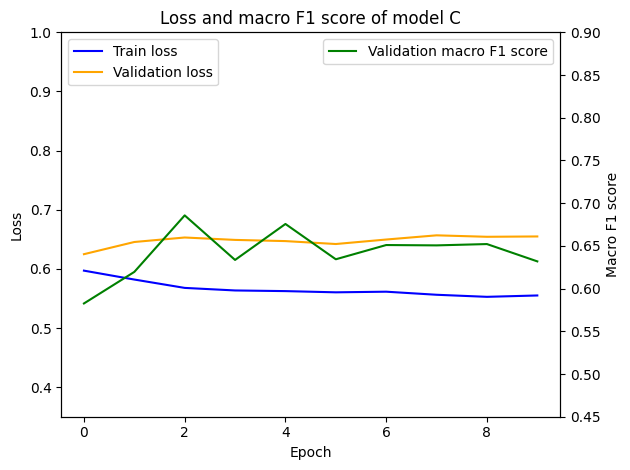

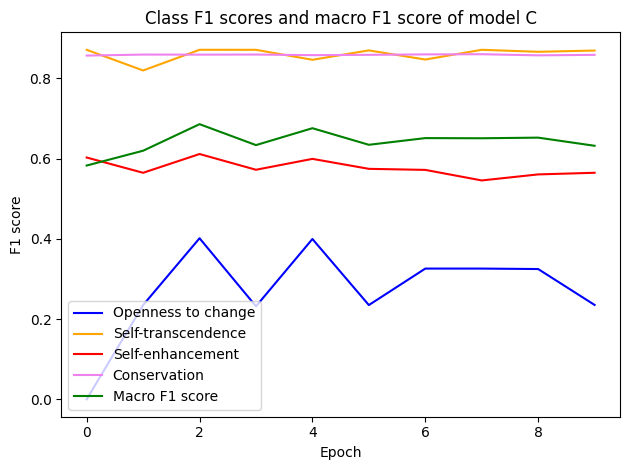

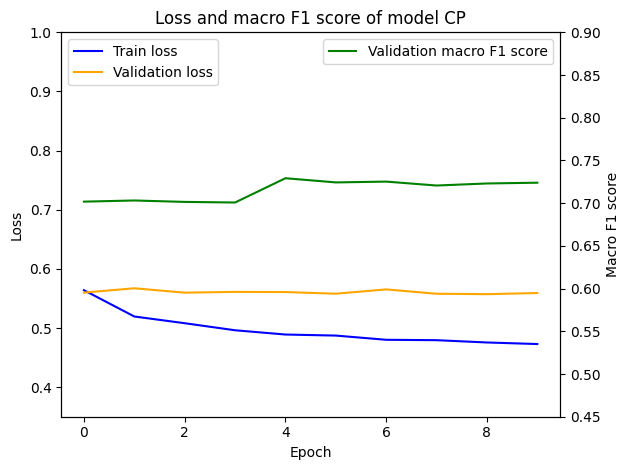

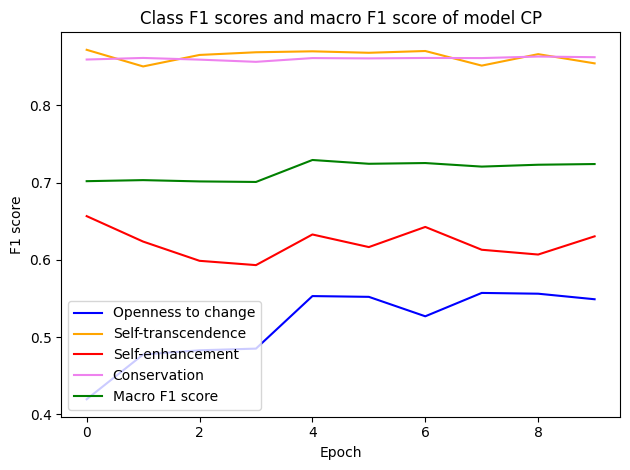

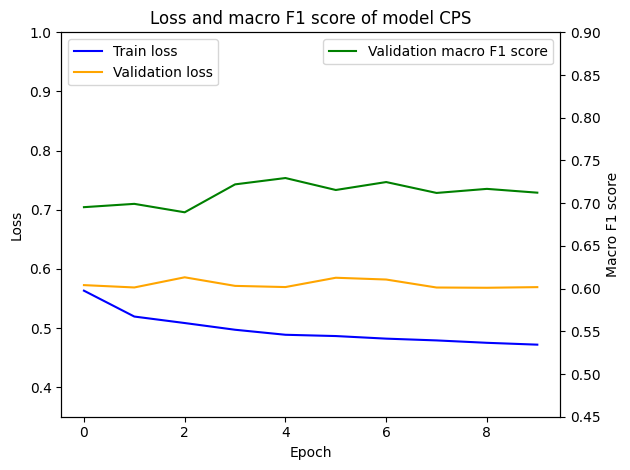

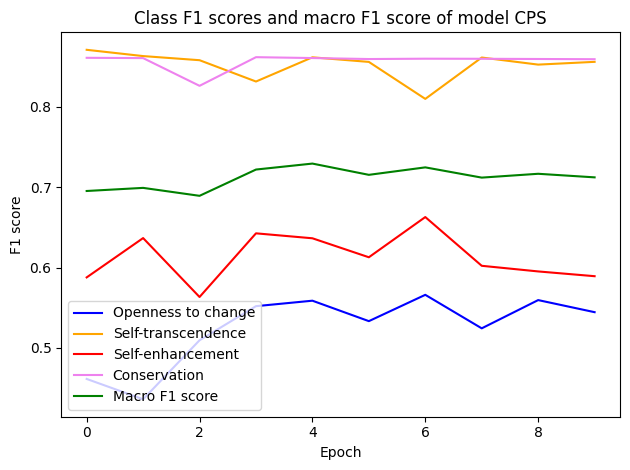

In [16]:
generate_training_history_plots(histories)

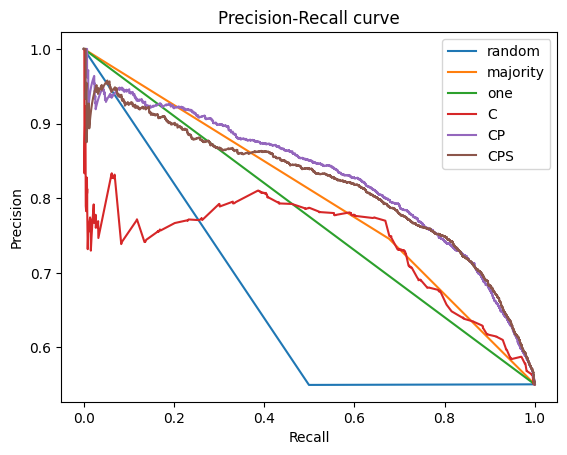

In [17]:
generate_precision_recall_curve(outputs_dict, labels, crisp_predictions_dict)

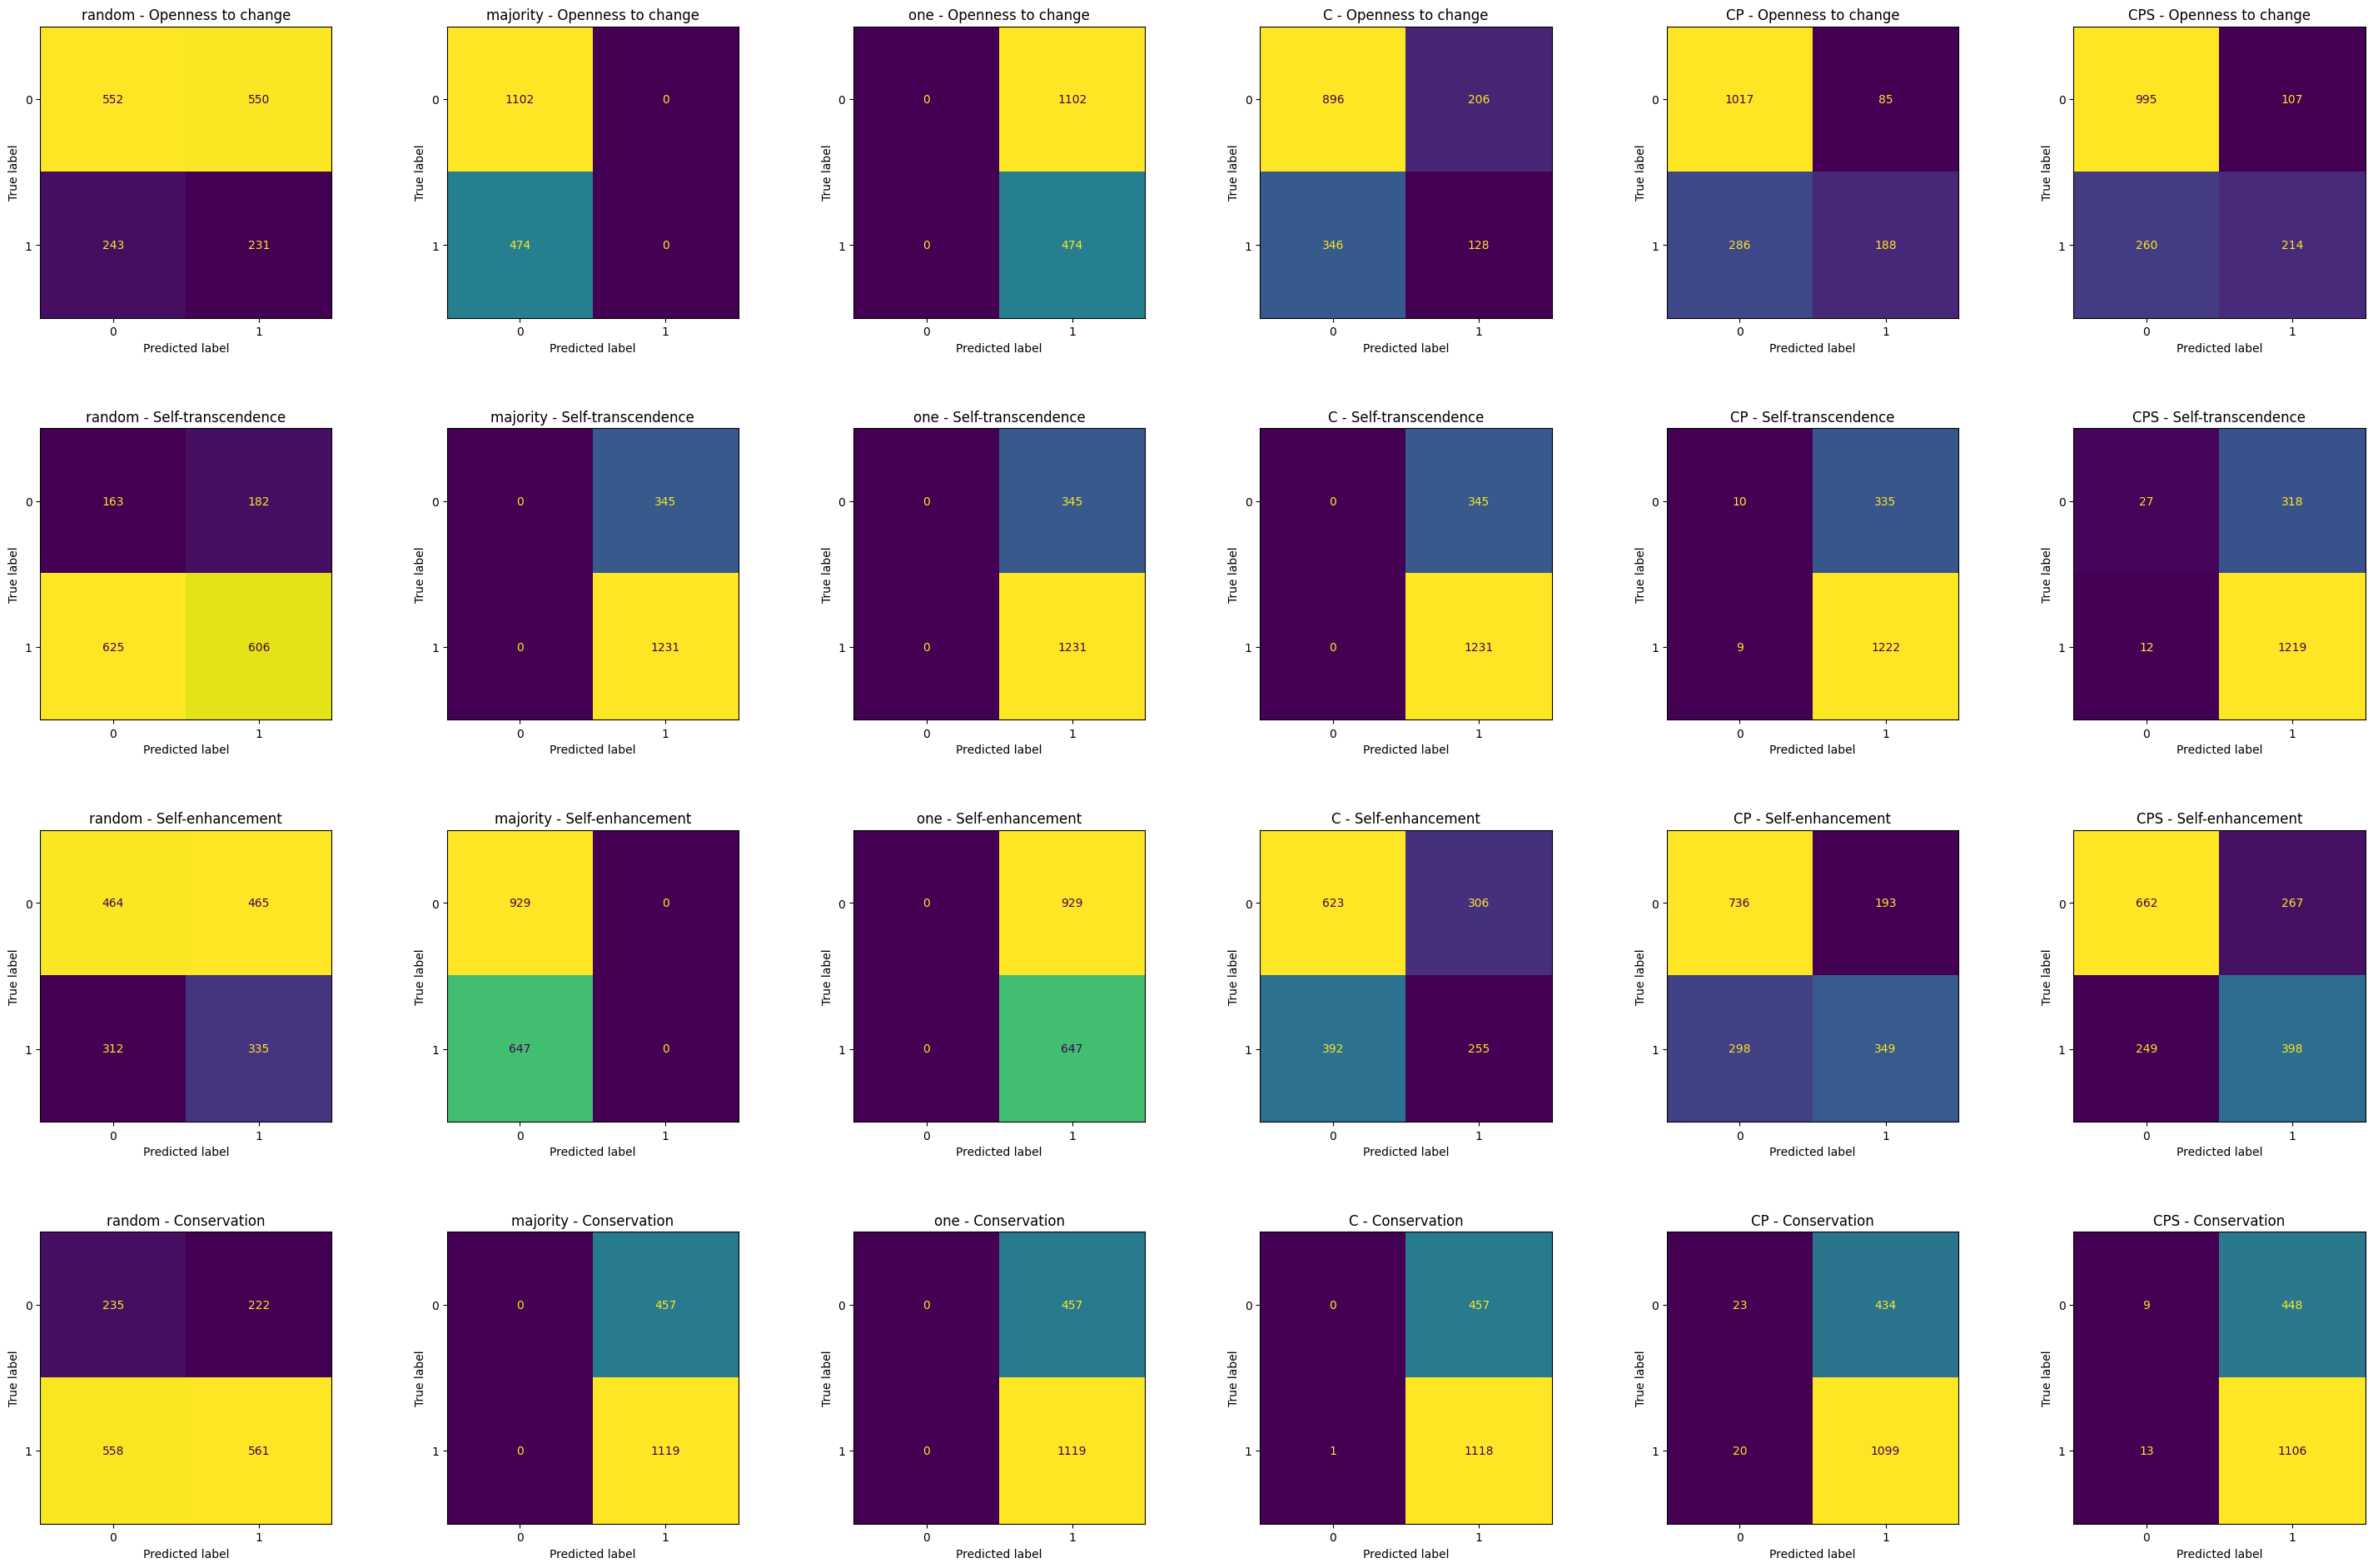

In [18]:
generate_confusion_matrix(outputs_dict, labels, crisp_predictions_dict)

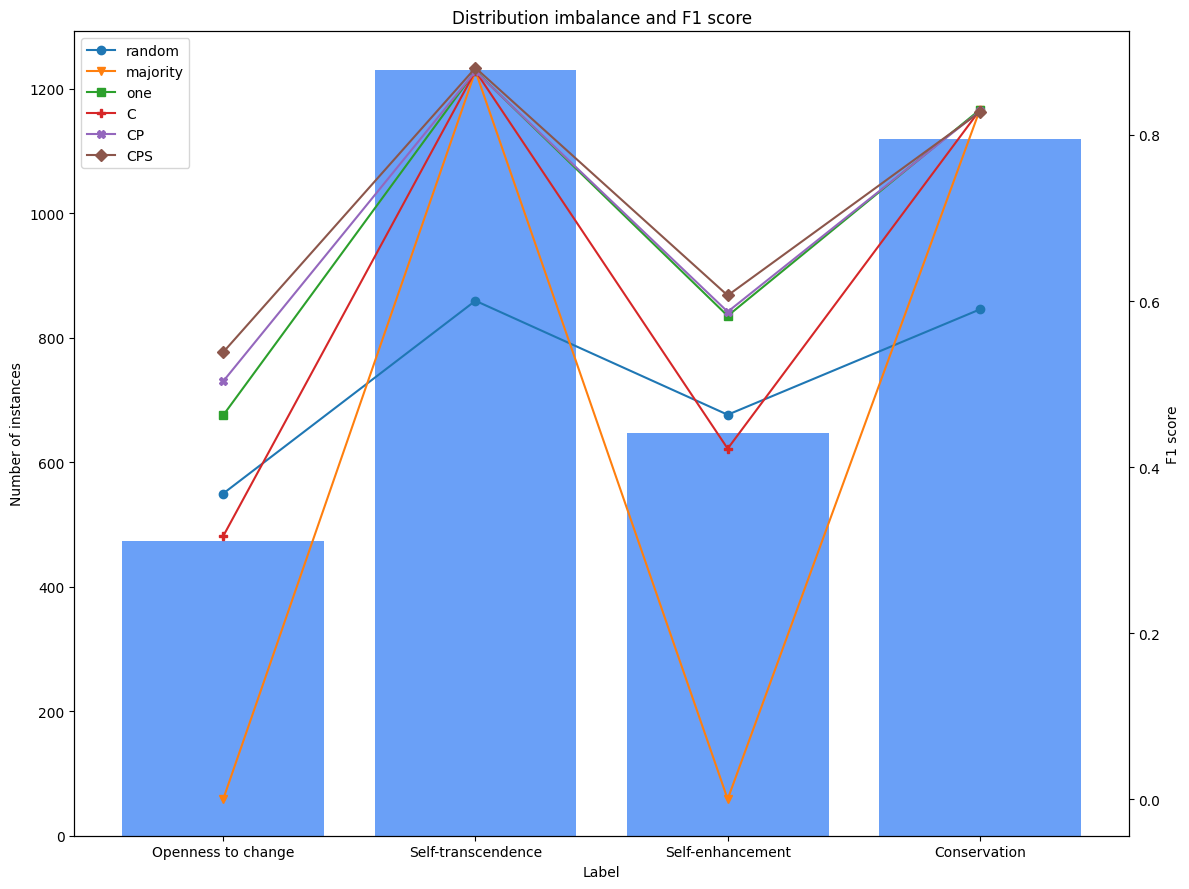

In [19]:
generate_bar_plot_with_f1_scores(outputs_dict, labels, crisp_predictions_dict)

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End